# Learning With Generative Models - Discriminators as approximations to likelihood ratios


Ratios of probabilities form an important part of Generative models, whether explicit as in the case of VAEs or implicit in the case of GANs. Even if we are computing the KL-divergence between two distributions, this usually boils down to computing the average over samples of the logarithm of two probability distributions.

For situations where we do not have a form for one or both of the models, computing the ratio of two distributions is not possible! 

In this post, I explore a method used frequently in recent publications, to estimate ratios of probabilities even when we do not have a form for one or both of them. 

## Estimating ratios using Logistic Regression

Let's say we have a model, $q$, and some true distribution, $p$, we are looking to make inferences about.

$q \sim U[-20,20]$

$p \sim N(5, 0.2)$

Let's imagine p is not knowable to us, we have some samples but no idea the model behind them. 

What we can do is assign label y=1 to samples from p, and then draw the same number of samples from q, and label these y=0.

Following the same line of reasoning as [ESL](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) section 14.24, Bayes theory tells us:

$P(Y=1 \mid X) = \frac{P(X \mid Y=1)}{P(X \mid Y=1) + P(X \mid Y=0)}$

Where, by definition;

$P(X \mid Y=1) = p(x)$

$P(X \mid Y=0) = q(x)$

$P(Y=1 \mid X) = \frac{1}{1 + \frac{q(x)}{p(x)}} \ \ \ \ \ \ \ \ \ \ \ \ \ \    (1)$

If we switch our approach for a second, we can write the objective for a logistic regression as:

$\frac{1}{1+exp(-f(X)W)}    \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \    \ \ \ \      (2)$

Where we have made use of the basis function expansion, and leave f() as some unspecified basis function that is sufficiently flexible.

Comparing equations 1 and 2, it is clear that $exp(-f(X)W)$ is equal to the ratio of q and p, subject to a sufficient form of f().

The advantage of equation 2 is that we don't need to know the probability distributions, we just need samples and a sufficiently flexible basis function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
%matplotlib inline

In [2]:
x1 = np.random.uniform(low=-20, high=20, size=(300,1))
x2 = np.random.normal(loc=5, scale=2, size=(300,1))

y1 = np.zeros_like(x1)
y2 = np.ones_like(x2)

In [3]:
def basis(x):
    """A Basis function that is sufficiently flexible to model the problem."""
    return np.concatenate([x,x**2], axis=1)

In [4]:
x = np.concatenate([x1,x2])

x= basis(x)

y = np.concatenate([y1, y2]).ravel()

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
lr = LogisticRegression()

In [7]:
lr.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
xtest_ = np.arange(-10,20).reshape(-1,1)
xtest= basis(xtest_)

In [9]:
ps = lr.predict_proba(xtest)

In [10]:
est = ps[:,1]/ps[:,0]

In [11]:
truth = norm.pdf(xtest_,loc=5, scale=2,)*40 #p(x)/q(x)

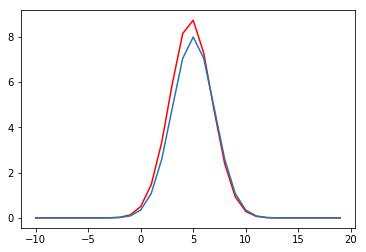

In [12]:
plt.plot(xtest_, est, c='r')
plt.plot(xtest_, truth)

As this figure shows, we actually get a very good approximation for the true ratio, and if we use more samples, this will be exact. The 2nd degree polynomial used in the basis function is sufficient, and if we use more samples the estimate will converge on the truth.

## The general case

The form in the previous example is not sufficiently flexible for complex distributions. A linear function of a basis function of X is ok, but it requires us to know the combination of features we need to sufficiently model the ratio function. If we rewrite $f(x)W$ as $g(x)$, we can include non-linear functions of arbitrary complexity. 

We can then make $g(x)$ be a neural network. We can then reach an equivalent conclusion as the logistic regression example, if we define a discriminator network, that takes input x, and has a logistic sigmoid as the final activation function. In this formulation, g(x) is the input to the final activation function, and so the neural network can be written as:

$\frac{1}{1+exp(-g(x))}    \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \    \ \ \ \      (3)$

Comparing with equation 1, the ratio of $p$ and $q$ is equal to $exp(-g(x))$ in the general case. 

If the network is sufficiently flexible, and we train it to optimality, our approach used above is still valid to estimate the ratio.

# Summary

In this post we have shown how we can equate discriminators and probability ratios. This is an important result that is used in recent work. By the converse logic, we can also see how implicit models which utilise discriminators are approximating ratios of probability distributions.